# Predicting Soybean Spot Price Change with "Trade War" Related Tweets 

#### FINA 4350 Text Analytics and Natural Language Processing in Finance and Fintech (2019-20 Semester 1)<a class="tocSkip">


*Coded by Zhang Xinyi *

## Background:

In this tutorial we will learn

1. Interpret the black-box model through global and local model agnostic methods.
2. Basic application of `InterpretML`,`lime` and `shap`.


## Abstract:

1. Supervised text analytics machine learning.
2. `lime`: [link](https://lime-ml.readthedocs.io/en/latest/)
3. `shap`: [link](https://github.com/slundberg/shap#citations)
4. `InterpretML`: [link](https://github.com/microsoft/interpret)
5. `pycebox`: [link](http://austinrochford.github.io/PyCEbox/docs/)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import string
import re
import eli5
import sys

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from collections import Counter
from eli5.sklearn import PermutationImportance
from pandasql import sqldf



import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

## Import raw tweet data and merge it data with lagged spot price data

Data source:

In [2]:
#Import raw twitter data and merge Twitter data
df = pd.read_csv('./data-streaming-tweets.csv')
#Convert to datetime64 and convert UTC time used by Twitter to Eastern Time (New York).
df.date = pd.to_datetime(df.date) - np.timedelta64(5, 'h')
df.date = df.date.dt.date     # Remove time part, only keep date.
#remove data for 01-Dec-2019 as we cutoff at the end of Nov
df = df[df['date']!= df.iloc[3324600]['date']]

#Import Spot price information
SpotPrice = pd.read_csv('./ChangeDateNew.csv')
SpotPrice.date = pd.to_datetime(SpotPrice.date)
SpotPrice.date = SpotPrice.date.dt.date  
SpotPrice['Lag_PriceChange'] = SpotPrice.Price_Change.shift(-1) # Lag the price change

#Merge Spot price with raw data
df = pd.merge(df, SpotPrice, how='left',on='date')

df.tail()                                    

,name,followers,date,tweet,Price,Price_Change,Lag_PriceChange
3322349,KASDad,3196,2019-11-30,and globex trading tomw should be most interes...,8.7675,-0.0625,-0.0625
3322350,borisman1984,82,2019-11-30,this was tweeted 2 weeks ago and still no take...,8.7675,-0.0625,-0.0625
3322351,PortfolioBuzz,1261,2019-11-30,track news with various time frames for $djia ...,8.7675,-0.0625,-0.0625
3322352,mistergray11,36,2019-11-30,8. the #euphoriameter however rose to a 14-mon...,8.7675,-0.0625,-0.0625
3322353,ynotttony,1677,2019-11-30,stocks and a window of opportunity,8.7675,-0.0625,-0.0625


In [3]:
#data inspection
DailyPosts=df.groupby(['date']).size()
DailyPosts.to_csv(r'/Users/zhangxinyi/Desktop/DailyPosts.csv')

## Filter trade war related tweets and cut the "Lagged price change" into quantiles of low, medium, high (lagged) price change.



In [4]:
#Filter related tweets
TradewarDf=df[df['tweet'].str.contains('trade war')|df['tweet'].str.contains('tariff')]
TradewarDf=TradewarDf[~TradewarDf['tweet'].str.contains('mexic')]
TradewarDf.reset_index(drop=True,inplace=True)

# Cut into quantiles of low, medium, high (lagged) returns.
TradewarDf['q_Lag_PriceChange'] = pd.qcut(TradewarDf.Lag_PriceChange, 3, labels=False)

TradewarDf.head()

,name,followers,date,tweet,Price,Price_Change,Lag_PriceChange,q_Lag_PriceChange
0,TradinWithVeebs,19,2018-02-04,$spy trade tariffs us reciprocating taxes,9.8875,-0.0525,-0.0525,0
1,RediminMagazine,1665,2018-02-13,#mining $gld #energy #economy $es $oil #china ...,9.9725,0.0000,-0.0375,0
2,MarketRealist,3790,2018-02-16,$x and $aa pop on potential trump administrati...,9.9725,-0.0075,0.0000,1
3,ZARTechnical,106,2018-02-16,$spx - nothing like the start of a trade war a...,9.9725,-0.0075,0.0000,1
4,RediminMagazine,1774,2018-02-19,#mining $gld #energy #economy $es $oil commerc...,9.9725,0.0000,0.0225,1


## Text Preprocessing

In [5]:
#remove punctuation 

def remove_punctuation (text):
    no_punct=''.join([c for c in text if c not in string.punctuation])
    return no_punct

stop_words_lst = ['$spx', '$spy', '$es','$dji', '$djia', '$indu', '$ym','$nq', '$nasdaq', '$qqq','$tlt',
        '$gc', '$gld',
        '$ng', '$wti']

def remove_key (text):
    no_key=' '.join([c for c in text.split(' ') if c not in stop_words_lst])
    return no_key



lemmatizer = WordNetLemmatizer()
#Instantiate Lemmatizer
def word_lemmatizer (text):
    lem_text = [lemmatizer.lemmatize(i) for i in text]
    return lem_text

#Instantiate Stemmer
stemmer = PorterStemmer()
def word_stemmer(text):
    stem_text = ''.join([stemmer.stem(i) for i in text])
    return stem_text

#Remove Non-English words
words = set(nltk.corpus.words.words())

def remove_non_English_word(text):
    english_text = ''.join(w for w in nltk.wordpunct_tokenize(text) \
         if w.lower() in words or not w.isalpha())
    return english_text
def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')


def remove_website_links(text):

    no_website_links =text.replace('{html}',"") 
    no_website_links = re.sub(r'https?:\/\/.*[\r\n]*', '', no_website_links, flags=re.MULTILINE)

    return no_website_links
def remove_non_alphabetic_word(text):
    rem_num = re.sub('[0-9]+', '', text)
    return rem_num


def remove_punctuation (text):
    no_punct=''.join([c for c in text if c not in string.punctuation])
    return no_punct



#TradewarDf['tweet']=TradewarDf['tweet'].apply (lambda x: remove_punctuation(x))
#remove punctuation is skipped since sklearn take care of removing punctuation when tokenizing
TradewarDf['tweet']=TradewarDf['tweet'].apply (lambda x: remove_key(x))
TradewarDf['tweet']=TradewarDf['tweet'].apply (lambda x: remove_website_links(x))
TradewarDf['tweet']=TradewarDf['tweet'].apply (lambda x: deEmojify(x))
TradewarDf['tweet']=TradewarDf['tweet'].apply (lambda x: remove_non_alphabetic_word(x))
TradewarDf['tweet']=TradewarDf['tweet'].apply (lambda x: word_lemmatizer(x))
TradewarDf['tweet']=TradewarDf['tweet'].apply (lambda x: word_stemmer(x))
TradewarDf['tweet'][5]

'trump is imposing tariffs on china. not a big concern for the economy or stock market'

## Split the dataset & Convert Text to Numbers ( BoW )
Split of training/testing data on 1-11- 2019. construct Bag of Words for both training and testing data.  
Drop words that occurred in more than 90% of of the documents and those appears less than 20 times (roughly 0.05%)
The model results shows that using tf-idf gives us better outcome, the variable names indicating tf-idf  after this cell was not changed for the time being. 


In [6]:
#TradewarDf.iloc[36900]['date'] is 2019-11-01, 
#the date data type here is unfamiliar to the me so I failed to hard code the date
Training=TradewarDf[TradewarDf['date']<TradewarDf.iloc[36900]['date']]
Testing=TradewarDf[TradewarDf['date']>=TradewarDf.iloc[36900]['date']]
Testing.reset_index(drop=True,inplace=True)

#fit BoW with trainning data
v = CountVectorizer(stop_words='english',lowercase=True,  max_df = 0.9,min_df =20)

tfidf = v.fit(Training['tweet'])
#transform trainning&testing data
tfidf = v.transform(Training['tweet'])
tfidfTesting=v.transform(Testing['tweet'])


print('The shape of BoW sparce metrix for trainning data =',tfidf.shape)
print('The shape of BoW sparce metrix for testing data =', tfidfTesting.shape)


The shape of BoW sparce metrix for trainning data = (36889, 1631)
The shape of BoW sparce metrix for testing data = (1161, 1631)


In [7]:
# generate the x_train and y_train x_test y_test
x_train = tfidf
y_train = Training.iloc[:,7].values

x_test = tfidfTesting
y_test = Testing.iloc[:,7].values

In [8]:
# Convert the sparce metrix into data frame for future use
tfidfDF=pd.DataFrame(tfidf.todense())
tfidfTestingDF=pd.DataFrame(tfidfTesting.todense())

tfidfDF.columns = v.get_feature_names()
tfidfTestingDF.columns=v.get_feature_names()

tfidfTestingDF.head()

,aapl,able,abt,according,acinvestorblog,act,action,activity,actual,actually,...,yesterday,yesterdays,yield,yields,yinn,yr,yuan,zero,zerohedge,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 1. Multiple layer Percepton (neural network)  Model
Black-box Modeling  

The fitted model is used both for direct prediction and further variable selection. (Term reduction). 

  


#### 1.1 MLP-NN Model with all 1631 variables(Terms)


In [9]:
X_train_NN, y_train_NN = tfidfDF.iloc[:, :].values, Training['q_Lag_PriceChange']
X_test_NN, y_test_NN = tfidfTestingDF.iloc[:, :].values, Testing['q_Lag_PriceChange']
feature_names = tfidfDF.columns[:].values

In [10]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(max_iter=1000, random_state=0,hidden_layer_sizes=(200,))
clf.fit(X_train_NN, y_train_NN)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(200,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=0, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [11]:
y_pred_train_NN=clf.predict(X_train_NN) 
y_pred_test_NN=clf.predict(X_test_NN)

Training['MLP-NN Predict'] = pd.Series(y_pred_train_NN)
Testing['MLP-NN Predict'] = pd.Series(y_pred_test_NN)


accuracy_train_NN = accuracy_score(y_train, y_pred_train_NN)
accuracy_test_NN = accuracy_score(y_test, y_pred_test_NN)


print('Accuracy on predict Price change for NN Model on the training set =', np.round(accuracy_train_NN,4))
print('Accuracy on predict Price change for NN Model on the testing set =', np.round(accuracy_test_NN,4))



Accuracy on predict Price change for NN Model on the training set = 0.852
Accuracy on predict Price change for NN Model on the testing set = 0.3204


### Variable Importance (VI)
- One can evaluate the variable importance through the metric score variation caused by the feature value permutation. Ideally, if one feature (variable) is important to the model, a small value perturbation leads to a significant change on the metric score such as the accuracy and $R^2$. 
- We use the package `eli5` ([github](https://github.com/TeamHG-Memex/eli5), [API doc](https://eli5.readthedocs.io/en/latest/overview.html)) to perform the permutation based importance evaluation.

In [13]:
# define a permutation importance object
# a gerneral way to calculate importance
# some machine learning method like random forest has build-in ways to calculate Variable Importance
perm = PermutationImportance(clf).fit(X_train_NN, y_train_NN)
# show the importance
eli5.show_weights(perm, feature_names=feature_names)

Weight,Feature
0.0679 ± 0.0020,speech
0.0663 ± 0.0012,friday
0.0589 ± 0.0018,game
0.0474 ± 0.0015,tradewar
0.0245 ± 0.0004,china
0.0231 ± 0.0013,trade
0.0222 ± 0.0013,trump
0.0154 ± 0.0011,rt
0.0142 ± 0.0014,wars
0.0123 ± 0.0008,facebook


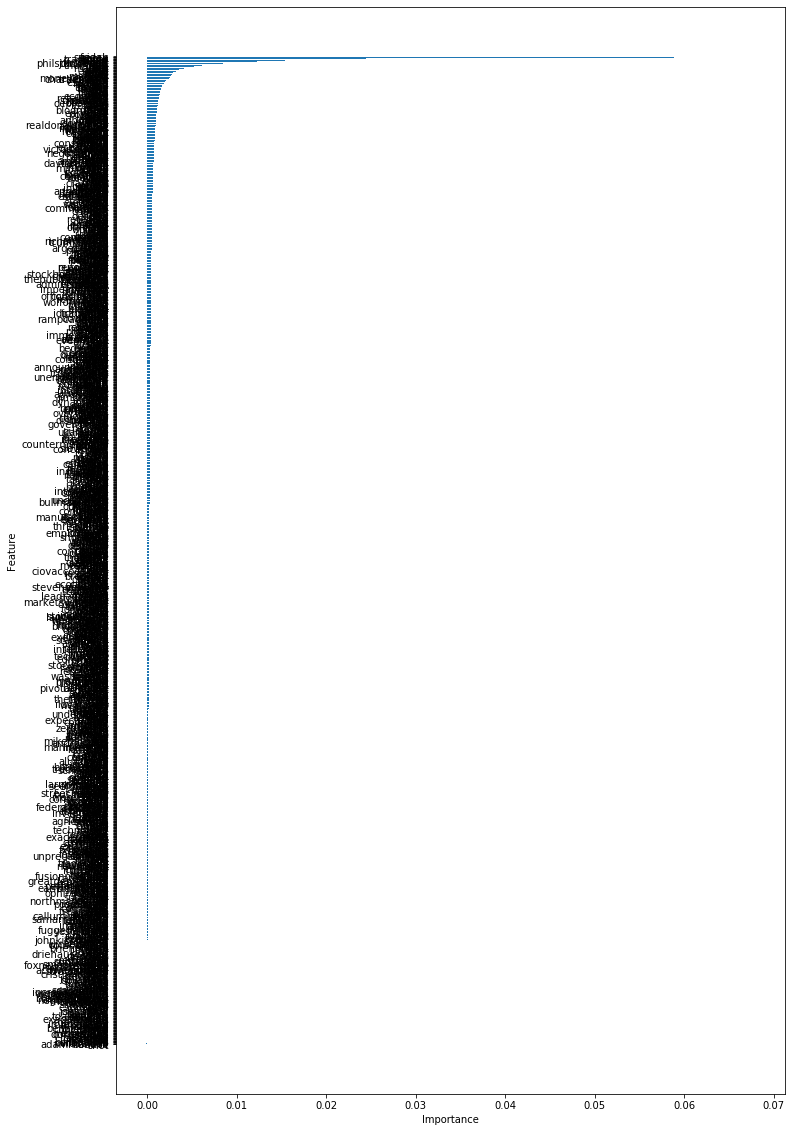

In [14]:
# importance in decreasing order
imp_ord = np.argsort(perm.feature_importances_)

plt.figure(figsize=(12,20))
yaxis = np.arange(len(perm.feature_importances_))*1.2
plt.barh(y = yaxis,width = perm.feature_importances_[imp_ord])
plt.yticks(yaxis,feature_names[imp_ord])
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.show()

## Select the top 100 important terms to run the model

In [15]:
WeightDF=eli5.explain_weights_df(perm, feature_names=feature_names)
WeightDF.head(100)

,feature,weight,std
0,speech,0.067868,0.001024
1,friday,0.066253,0.000615
2,game,0.058868,0.000905
3,tradewar,0.047353,0.000732
4,china,0.024479,0.000225
5,trade,0.023064,0.000656
6,trump,0.022218,0.000644
7,rt,0.015360,0.000558
8,wars,0.014205,0.000705
9,facebook,0.012253,0.000417


In [16]:
imp_100 = WeightDF["feature"][0:100].tolist()
impX_100_DF=tfidfDF[imp_100].copy()
impX_100_DF_Testing=tfidfTestingDF[imp_100].copy()
impX_100_DF.head()

,speech,friday,game,tradewar,china,trade,trump,rt,wars,facebook,...,know,eem,th,earnings,possible,did,crazy,wants,tweet,line
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 1.2 MLP-NN Model with the top 100 most important variables(Terms)



In [17]:
X_train_NN_imp100, y_train_NN_imp100 = impX_100_DF.iloc[:, :].values, Training['q_Lag_PriceChange']
X_test_NN_imp100, y_test_NN_imp100 = impX_100_DF_Testing.iloc[:, :].values, Testing['q_Lag_PriceChange']
feature_names_imp100 = impX_100_DF.columns[:].values

clf_imp100 = MLPClassifier(max_iter=1000, random_state=0,hidden_layer_sizes=(200,))
clf_imp100.fit(X_train_NN_imp100, y_train_NN_imp100)

y_pred_train_NN_imp100=clf_imp100.predict(X_train_NN_imp100) 
y_pred_test_NN_imp100=clf_imp100.predict(X_test_NN_imp100)



Training['MLP-NN-100 Predict'] = pd.Series(y_pred_train_NN_imp100)
Testing['MLP-NN-100 Predict'] = pd.Series(y_pred_test_NN_imp100)



accuracy_train_NN_imp100 = accuracy_score(y_train, y_pred_train_NN_imp100)
accuracy_test_NN_imp100 = accuracy_score(y_test, y_pred_test_NN_imp100)


print('Accuracy on predict Price change for NN Model (imp100ortant variables) on the training set =', np.round(accuracy_train_NN_imp100,4))
print('Accuracy on predict Price change for NN Model (imp100ortant variables) on the testing set =', np.round(accuracy_test_NN_imp100,4))



Accuracy on predict Price change for NN Model (imp100ortant variables) on the training set = 0.7119
Accuracy on predict Price change for NN Model (imp100ortant variables) on the testing set = 0.4599


## Select the top 19 important terms shown in the eli5.show_weights table to run the model

In [18]:
names=['speech','friday','game','tradewar','china','trade','trump','rt','wars','facebook','dia','war','tarrifs','new','tsla','lng','market']
impX_DF=tfidfDF[names].copy()
impX_DF_Testing=tfidfTestingDF[names].copy()
impX_DF.head()

,speech,friday,game,tradewar,china,trade,trump,rt,wars,facebook,dia,war,tarrifs,new,tsla,lng,market
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### 1.3 MLP-NN Model with the top 19 most important variables(Terms)




In [19]:
X_train_NN_imp, y_train_NN_imp = impX_DF.iloc[:, :].values, Training['q_Lag_PriceChange']
X_test_NN_imp, y_test_NN_imp = impX_DF_Testing.iloc[:, :].values, Testing['q_Lag_PriceChange']
feature_names_imp = impX_DF.columns[:].values

clf_Imp = MLPClassifier(max_iter=1000, random_state=0,hidden_layer_sizes=(250,))
clf_Imp.fit(X_train_NN_imp, y_train_NN_imp)

y_pred_train_NN_imp=clf_Imp.predict(X_train_NN_imp) 
y_pred_test_NN_imp=clf_Imp.predict(X_test_NN_imp)



Training['MLP-NN-19 Predict'] = pd.Series(y_pred_train_NN_imp)
Testing['MLP-NN-19 Predict'] = pd.Series(y_pred_test_NN_imp)



accuracy_train_NN_imp = accuracy_score(y_train, y_pred_train_NN_imp)
accuracy_test_NN_imp = accuracy_score(y_test, y_pred_test_NN_imp)


print('Accuracy on predict Price change for NN Model (important variables) on the training set =', np.round(accuracy_train_NN_imp,4))
print('Accuracy on predict Price change for NN Model (important variables) on the testing set =', np.round(accuracy_test_NN_imp,4))


Accuracy on predict Price change for NN Model (important variables) on the training set = 0.539
Accuracy on predict Price change for NN Model (important variables) on the testing set = 0.4048


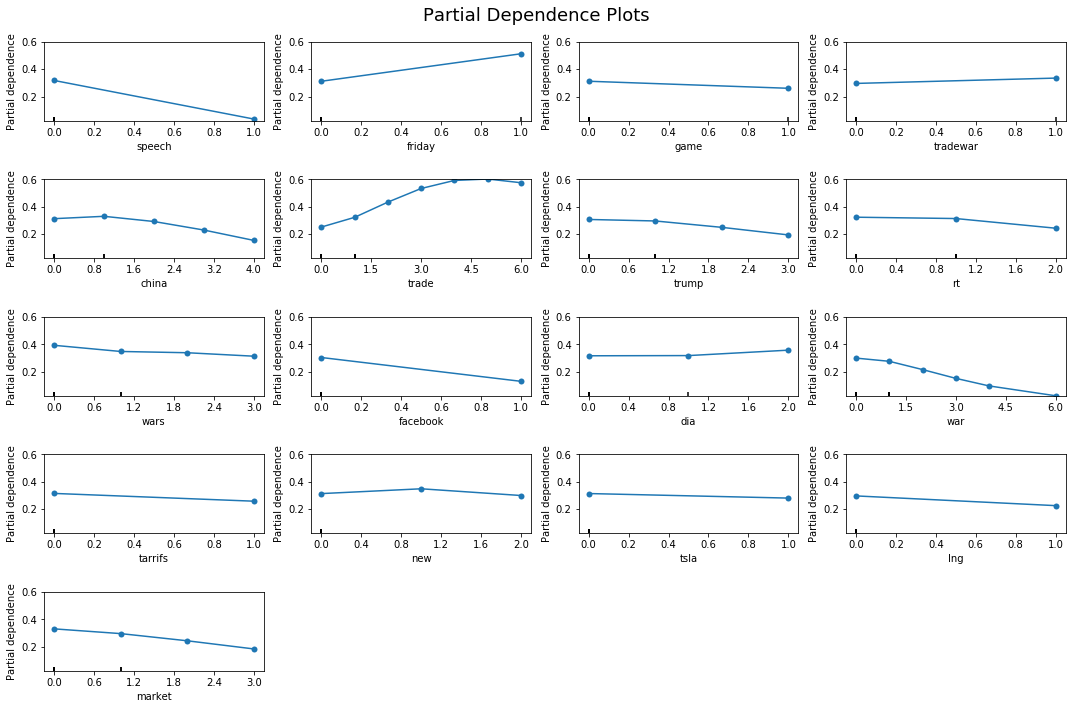

In [20]:
from sklearn.inspection import plot_partial_dependence as pdp
#plot_partial_dependence is introduced in the latest version of sklearn
n_cols = 4
n_rows = feature_names_imp.shape[0]//n_cols + 1

fig = plt.figure(figsize=(15, 2*n_rows))
#pdp (classification, which data you use to draw,...)
pdp(clf_Imp, impX_DF, features=feature_names_imp, feature_names=feature_names_imp,
    n_cols=n_cols, fig=fig, line_kw={'marker': 'o', 'markeredgecolor': 'None'},target=0)

plt.suptitle('Partial Dependence Plots', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.97])

## 2. Naive Bayes Model

#### 2.1 Naive Bayes Model with all 1631 variables(Terms)

In [21]:
#Fit MultinomialNB model with trainning data
nb = MultinomialNB()            # MultinomialNP(alpha=0.5)
nb.fit(tfidf, Training.q_Lag_PriceChange) 

#Predict Training data
y_pred_train_NB=nb.predict(tfidf) 
Training['NB Predict'] = pd.Series(nb.predict(tfidf))

#Predict Testing data
y_pred_test_NB=nb.predict(v.transform(Testing['tweet']))
Testing['NB Predict'] = pd.Series(nb.predict(tfidfTesting))


Actural_training_NB = Training.iloc[:,7].values
Predict_training_NB = y_pred_train_NB
accuracy_Price_Change_training_NB = accuracy_score(Actural_training_NB, Predict_training_NB)


Actural_Testing_NB = Testing.iloc[:,7].values
Predict_Testing_NB = y_pred_test_NB
accuracy_Price_Change_testing_NB = accuracy_score(Actural_Testing_NB, Predict_Testing_NB)


print('Accuracy on predict Price change for NB Model on trainning data =', np.round(accuracy_Price_Change_training_NB,4))
print('Accuracy on predict Price change for NB Model on testing data =', np.round(accuracy_Price_Change_testing_NB,4))

Accuracy on predict Price change for NB Model on trainning data = 0.5562
Accuracy on predict Price change for NB Model on testing data = 0.3213


#### 2. 2 Naive Bayes Model with the top 100 most important variables(Terms)

In [22]:
#Fit MultinomialNB_imp100 model with trainning data
NB_imp100 = MultinomialNB()            # MultinomialNP(alpha=0.5)
NB_imp100.fit(impX_100_DF.iloc[:, :].values, Training.q_Lag_PriceChange) 


#Predict Training data
NB_imp100.predict(impX_100_DF.iloc[:, :].values) 
Training['NB-100 Predict'] = pd.Series(NB_imp100.predict(impX_100_DF.iloc[:, :].values))

#Predict Testing data
NB_imp100.predict(impX_100_DF_Testing.iloc[:, :].values)
Testing['NB-100 Predict'] = pd.Series(NB_imp100.predict(impX_100_DF_Testing.iloc[:, :].values))

Actural_training_NB_imp100 = Training.iloc[:,7].values
Predict_training_NB_imp100 = NB_imp100.predict(impX_100_DF.iloc[:, :].values) 
accuracy_Price_Change_training_NB_imp100 = accuracy_score(Actural_training_NB_imp100, Predict_training_NB_imp100)




Actural_Testing_NB_imp100 = Testing.iloc[:,7].values
Predict_Testing_NB_imp100 = NB_imp100.predict(impX_100_DF_Testing.iloc[:, :].values)
accuracy_Price_Change_testing_NB_imp100 = accuracy_score(Actural_Testing_NB_imp100, Predict_Testing_NB_imp100)


print('Accuracy on predict Price change for NB_imp100 Model on trainning data =', np.round(accuracy_Price_Change_training_NB_imp100,4))
print('Accuracy on predict Price change for NB_imp100 Model on testing data =', np.round(accuracy_Price_Change_testing_NB_imp100,4))

Accuracy on predict Price change for NB_imp100 Model on trainning data = 0.494
Accuracy on predict Price change for NB_imp100 Model on testing data = 0.5401


#### 2. 3 Naive Bayes Model with the top 19 most important variables(Terms)

In [23]:
#Fit MultinomialNB_imp model with trainning data
NB_imp = MultinomialNB()            # MultinomialNP(alpha=0.5)
NB_imp.fit(impX_DF.iloc[:, :].values, Training.q_Lag_PriceChange) 


#Predict Training data
NB_imp.predict(impX_DF.iloc[:, :].values) 
Training['NB-19 Predict'] = pd.Series(NB_imp.predict(impX_DF.iloc[:, :].values))

#Predict Testing data
NB_imp.predict(impX_DF_Testing.iloc[:, :].values)
Testing['NB-19 Predict'] = pd.Series(NB_imp.predict(impX_DF_Testing.iloc[:, :].values))

Actural_training_NB_imp = Training.iloc[:,7].values
Predict_training_NB_imp = NB_imp.predict(impX_DF.iloc[:, :].values)
accuracy_Price_Change_training_NB_imp = accuracy_score(Actural_training_NB_imp, Predict_training_NB_imp)




Actural_Testing_NB_imp = Testing.iloc[:,7].values
Predict_Testing_NB_imp = NB_imp.predict(impX_DF_Testing.iloc[:, :].values)
accuracy_Price_Change_testing_NB_imp = accuracy_score(Actural_Testing_NB_imp, Predict_Testing_NB_imp)


print('Accuracy on predict Price change for NB_imp Model on trainning data =', np.round(accuracy_Price_Change_training_NB_imp,4))
print('Accuracy on predict Price change for NB_imp Model on testing data =', np.round(accuracy_Price_Change_testing_NB_imp,4))

Accuracy on predict Price change for NB_imp Model on trainning data = 0.4748
Accuracy on predict Price change for NB_imp Model on testing data = 0.5969


## 3. Logistic model

#### 3.1 Logistic Model with all 1631 variables(Terms)

In [24]:
#Fit a logistic model on the training data with selected features
#by package sklearn LogisticRegression

logreg = LogisticRegression(C=1e8, solver='newton-cg')
logreg.fit(x_train, y_train)

y_pred_train_Logistic = logreg.predict(x_train)
y_pred_test_Logistic = logreg.predict(x_test)

Training['Logistic Predict'] = y_pred_train_Logistic
Testing['Logistic Predict'] = y_pred_test_Logistic

# The fitted model has the coefficients of:
#print("Coefficients :", np.round(logreg.intercept_,4), np.round(logreg.coef_,4))

accuracy_train_Logistic = accuracy_score(y_train, y_pred_train_Logistic)
accuracy_test_Logistic = accuracy_score(y_test, y_pred_test_Logistic)


print('Accuracy on predict Price change for Logistic Model on the training set =', np.round(accuracy_train_Logistic,4))
print('Accuracy on predict Price change for Logistic Model on the testing set =', np.round(accuracy_test_Logistic,4))




Accuracy on predict Price change for Logistic Model on the training set = 0.6579
Accuracy on predict Price change for Logistic Model on the testing set = 0.4143


#### 3.2 Logistic Model with the top 100 most important variables(Terms)

In [25]:
#Fit a logistic model on the training data with selected features
#by package sklearn LogisticRegression

logreg = LogisticRegression(C=1e8, solver='newton-cg')
logreg.fit(impX_100_DF, y_train)

y_pred_train_Logistic_100 = logreg.predict(impX_100_DF)
y_pred_test_Logistic_100 = logreg.predict(impX_100_DF_Testing)

Training['Logistic-100 Predict'] = y_pred_train_Logistic_100
Testing['Logistic-100 Predict'] = y_pred_test_Logistic_100

# The fitted model has the coefficients of:
#print("Coefficients :", np.round(logreg.intercept_,4), np.round(logreg.coef_,4))

accuracy_train_Logistic = accuracy_score(y_train, y_pred_train_Logistic_100)
accuracy_test_Logistic = accuracy_score(y_test, y_pred_test_Logistic_100)


print('Accuracy on predict Price change for Logistic Model(100 variable) on the training set =', np.round(accuracy_train_Logistic,4))
print('Accuracy on predict Price change for Logistic Model(100 variable) on the testing set =', np.round(accuracy_test_Logistic,4))





Accuracy on predict Price change for Logistic Model(100 variable) on the training set = 0.5319
Accuracy on predict Price change for Logistic Model(100 variable) on the testing set = 0.4126


#### 3.3 Logistic Model with the top 19 most important variables(Terms)

In [26]:
#Fit a logistic model on the training data with selected features
#by package sklearn LogisticRegression

logreg = LogisticRegression(C=1e8, solver='newton-cg')
logreg.fit(impX_DF, y_train)

y_pred_train_Logistic = logreg.predict(impX_DF)
y_pred_test_Logistic = logreg.predict(impX_DF_Testing)

Training['Logistic-19 Predict'] = y_pred_train_Logistic
Testing['Logistic-19 Predict'] = y_pred_test_Logistic

# The fitted model has the coefficients of:
print("Coefficients :", np.round(logreg.intercept_,4), np.round(logreg.coef_,4))
accuracy_train_Logistic = accuracy_score(y_train, y_pred_train_Logistic)
accuracy_test_Logistic = accuracy_score(y_test, y_pred_test_Logistic)


print('Accuracy on predict Price change for Logistic Model(20 variable) on the training set =', np.round(accuracy_train_Logistic,4))
print('Accuracy on predict Price change for Logistic Model(20 variable) on the testing set =', np.round(accuracy_test_Logistic,4))






Coefficients : [-0.419  -0.6362 -1.067 ] [[-2.4959e+00  5.4510e-01  1.5020e-01  3.5200e-01 -1.2540e-01  9.4000e-02
  -2.6340e-01  8.5200e-02 -5.6230e-01  5.4130e-01  9.8700e-02 -1.7180e-01
  -1.3461e+00 -8.4900e-02 -1.5730e-01  2.9609e+00 -4.3380e-01]
 [ 1.6131e+00 -4.3950e-01  9.4910e-01 -7.0380e-01  9.1500e-02 -7.9100e-02
   1.2700e-01 -1.0160e-01  8.9040e-01  8.0250e-01  2.7020e-01  3.7000e-03
   2.8947e+00  6.0400e-02 -1.2220e-01 -1.6725e+00  3.6450e-01]
 [ 5.2660e-01 -9.5400e-02 -1.4085e+00  3.8380e-01  3.5400e-02 -1.3100e-02
   1.6860e-01  1.7100e-02 -6.2750e-01 -3.7798e+00 -5.6560e-01  1.9950e-01
  -4.4813e+00  2.8000e-02  3.2540e-01 -3.7127e+00  2.4000e-03]]
Accuracy on predict Price change for Logistic Model(20 variable) on the training set = 0.4943
Accuracy on predict Price change for Logistic Model(20 variable) on the testing set = 0.5969


In [27]:
Training.to_csv(r'/Users/zhangxinyi/Desktop/BoWTraining.csv')
Testing.to_csv(r'/Users/zhangxinyi/Desktop/BoWTesting.csv')
WeightDF.to_csv(r'/Users/zhangxinyi/Desktop/BoWImportanceWordList.csv')